In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
#ROOT_DIR = os.getcwd()
ROOT_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO'
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO')

# Path to trained weights file
# Download this file and place in the root of your 
# project (See README file for details)
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")  #mask_rcnn_coco_0025.h5
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_0025.h5")


# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [2]:
PYCOCO_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/PythonAPI'
sys.path.append(PYCOCO_DIR)

# MS COCO Dataset
import coco_stuff as coco
config = coco.CocoConfig()
COCO_DIR = "/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/2017"  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    93
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()
print("Images: {}".format(len(dataset.image_ids)))

Image Directory:  /Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/2017/val2017
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
Images: 500


In [7]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 500
Classes: ['BG', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick', 'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone', 'wall-tile', 'wall-wood',

In [12]:
#ROOT_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/PythonAPI'

#sys.path.append(ROOT_DIR)

#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_0025.h5")

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/mask_rcnn_coco_0025.h5


## Inspect a Random Image

274
image ID: coco.87038 (274) http://cocodataset.org/#explore?id=87038
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 101)              min:    0.00000  max: 1024.00000
gt_class_id              shape: (6,)                  min:    5.00000  max:   92.00000
gt_bbox                  shape: (6, 4)                min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000


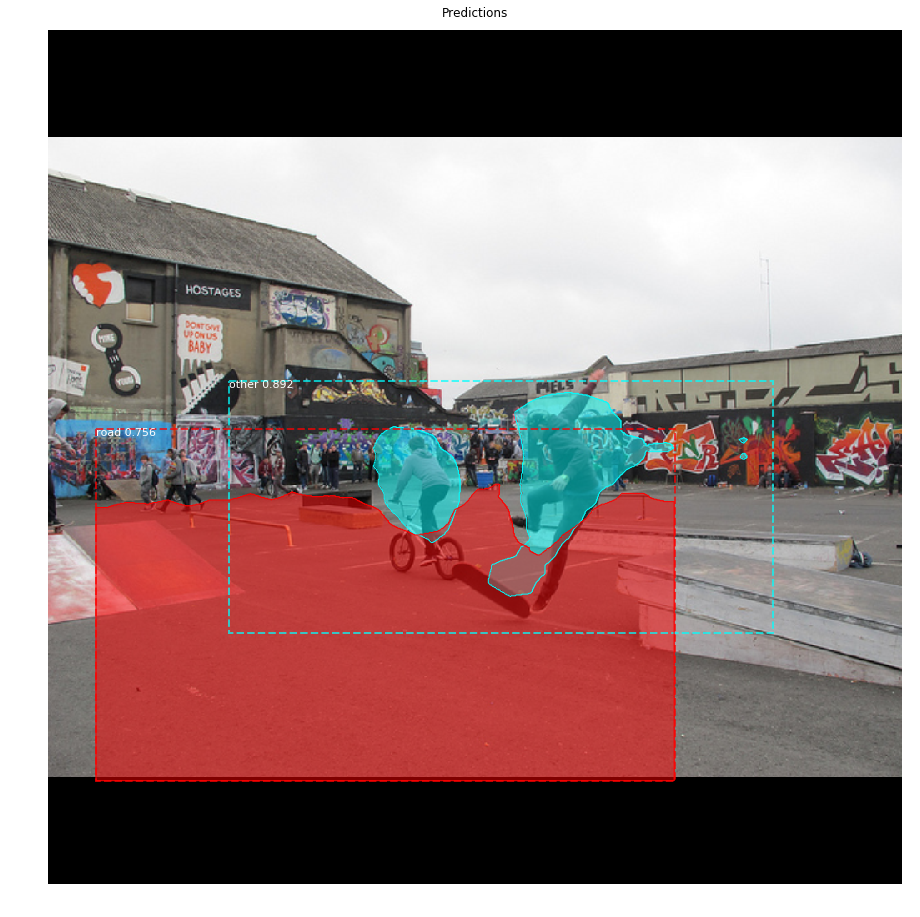

In [11]:
#image_id = random.choice(dataset.image_ids)
image_id = 274  #, 210, 48
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

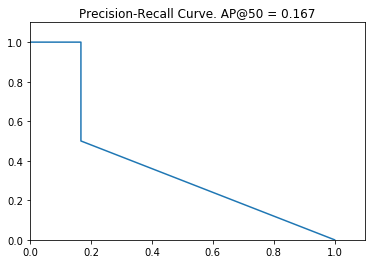

In [12]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

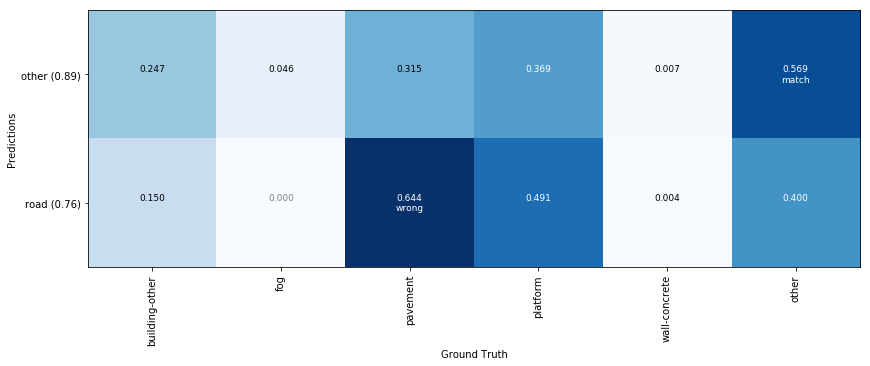

In [13]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [15]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id,
                              r['rois'], r['class_ids'], r['scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids = [274, 210, 48]
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

/Users/carlosbeas/anaconda/envs/conda3p5/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP @ IoU=50:  0.111111114422


## Region Proposal Network

### Targets

In [24]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -1.44816  max:    1.76777
positive_anchors         shape: (9, 4)                min:  -42.03867  max:  885.01934
negative_anchors         shape: (247, 4)              min:  -48.00000  max: 1173.01934
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (9, 4)                min:    0.00000  max: 1024.00012


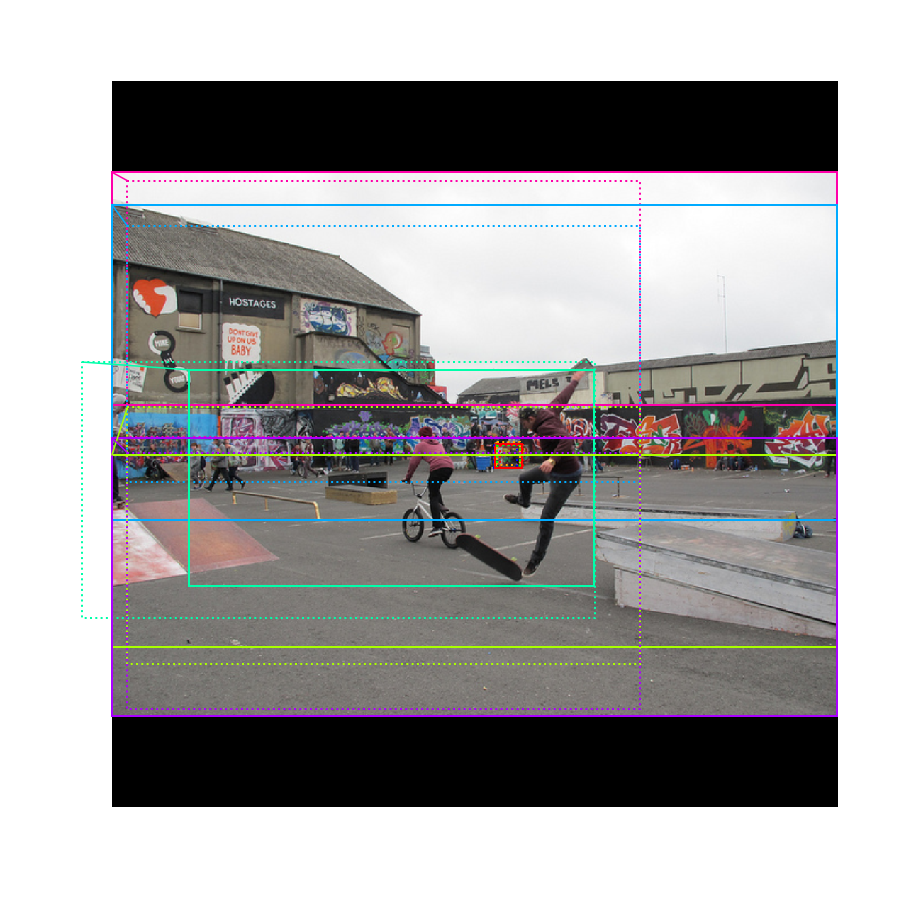

In [25]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### Predictions

In [26]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -16.00000  max: 1038.62744
refined_anchors          shape: (1, 6000, 4)          min: -4392.12451  max: 5942.49902
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1000.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


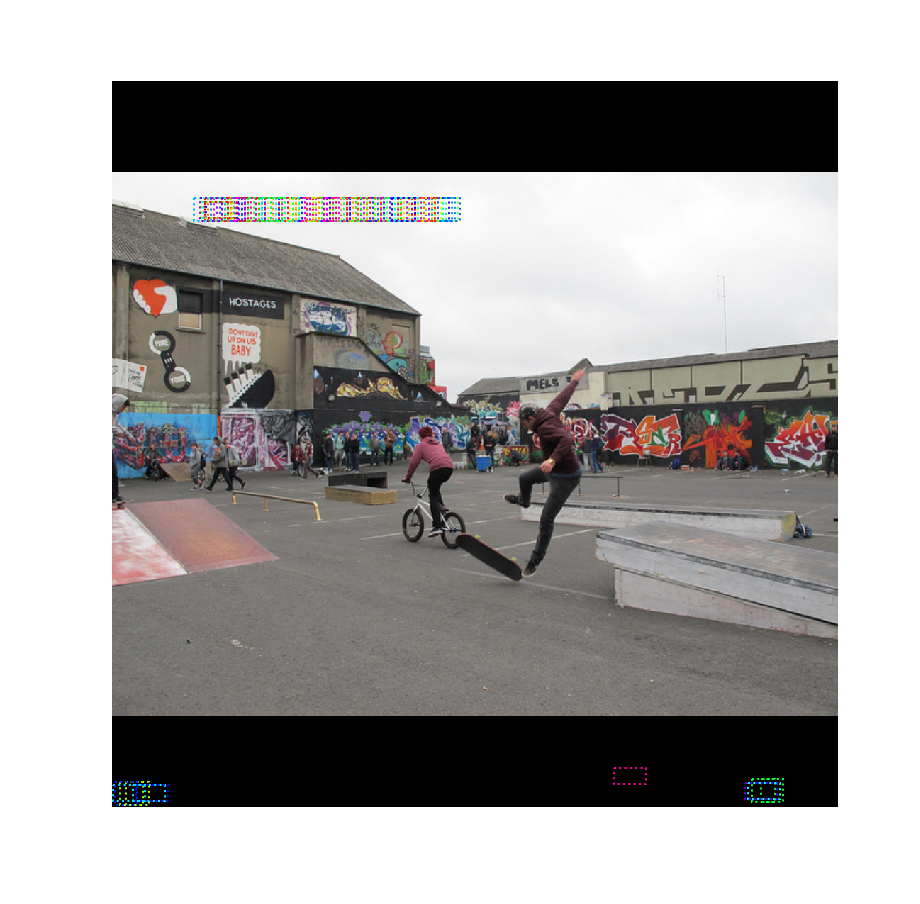

In [27]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

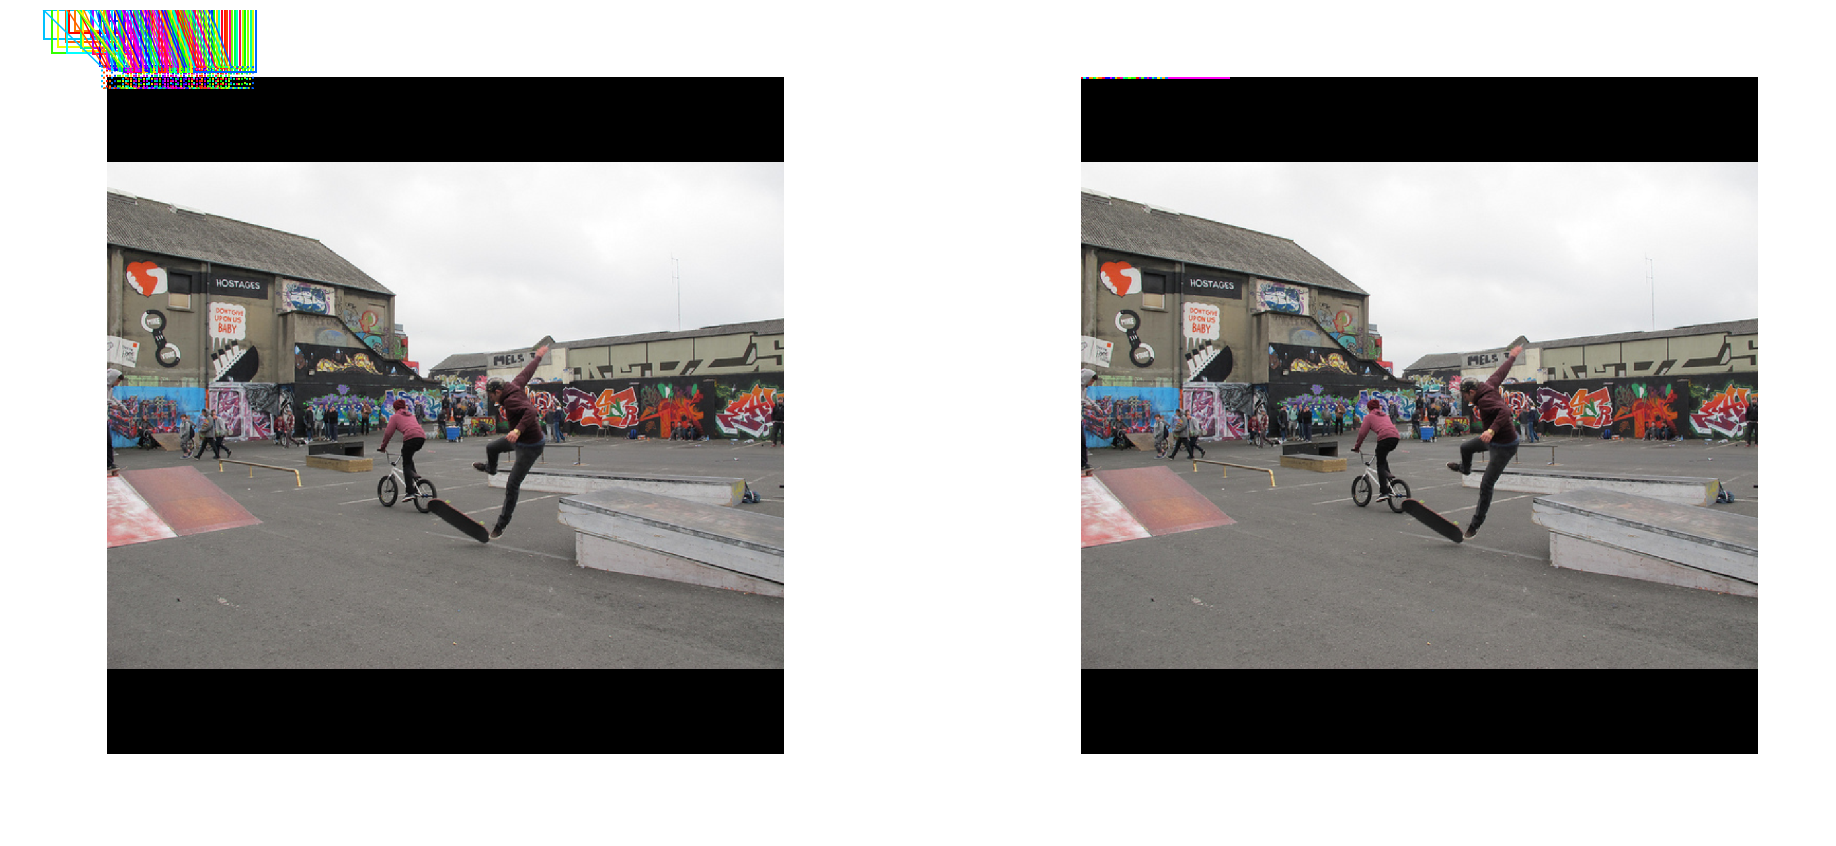

In [28]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

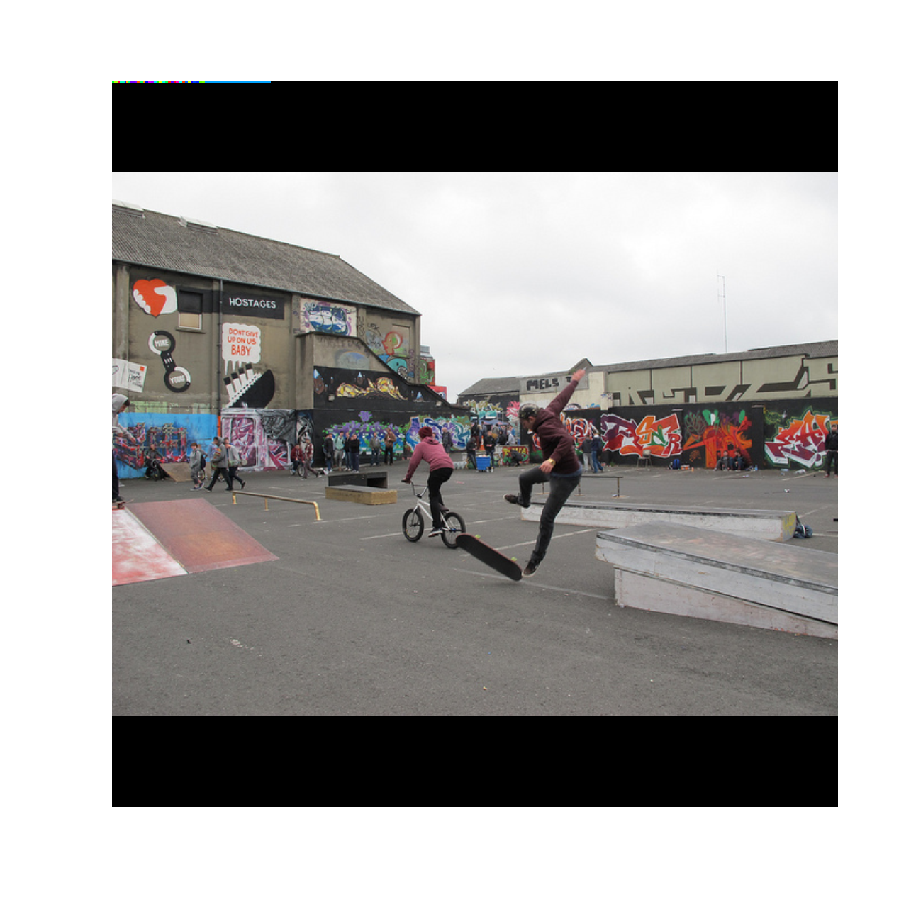

In [29]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

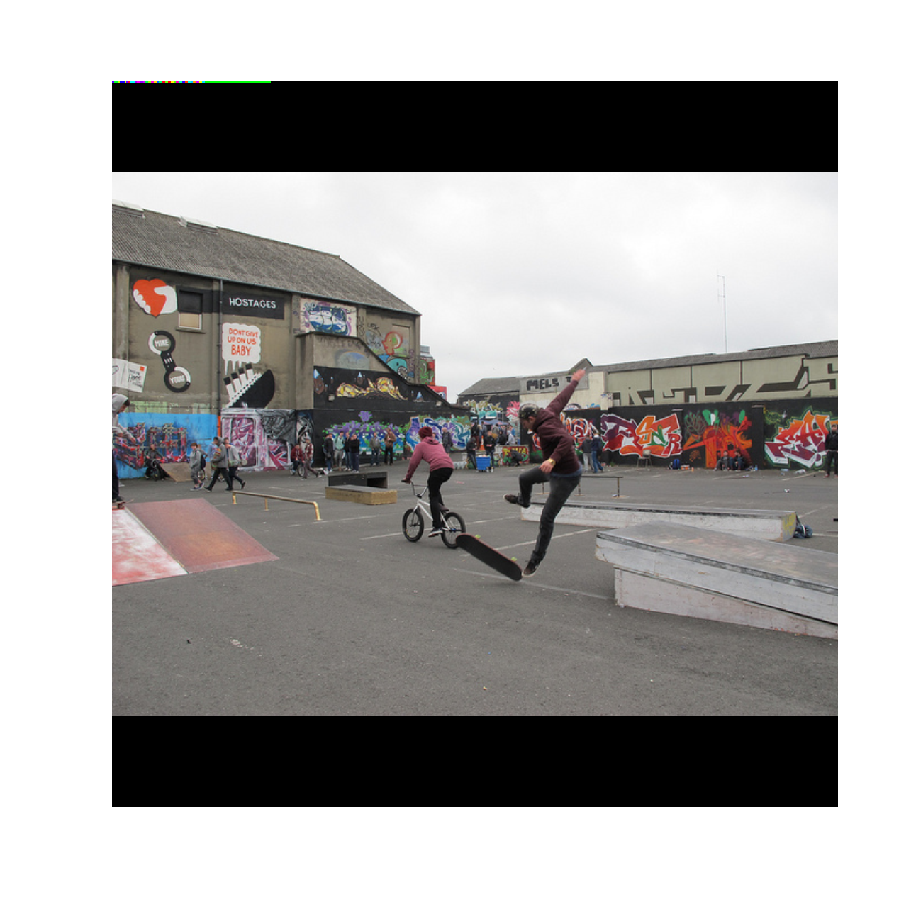

In [30]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [31]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))

All Anchors (261888)       Recall: 0.167  Positive anchors: 4
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 0.000  Positive anchors: 0


## Proposal Classifiation

### Proposal Classification

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

## Try New Image

In [10]:
# Build validation dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "val")

# Must call before using the dataset
dataset.prepare()
print("Images: {}".format(len(dataset.image_ids)))
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Image Directory:  /Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/2017/val2017
loading annotations into memory...
Done (t=1.53s)
creating index...
index created!
Images: 5000
Images: 5000
Classes: ['BG', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'stra

3695
image ID: coco.30675 (3695) http://cocodataset.org/#explore?id=30675
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 101)              min:    0.00000  max: 1024.00000
gt_class_id              shape: (6,)                  min:   20.00000  max:   92.00000
gt_bbox                  shape: (6, 4)                min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000


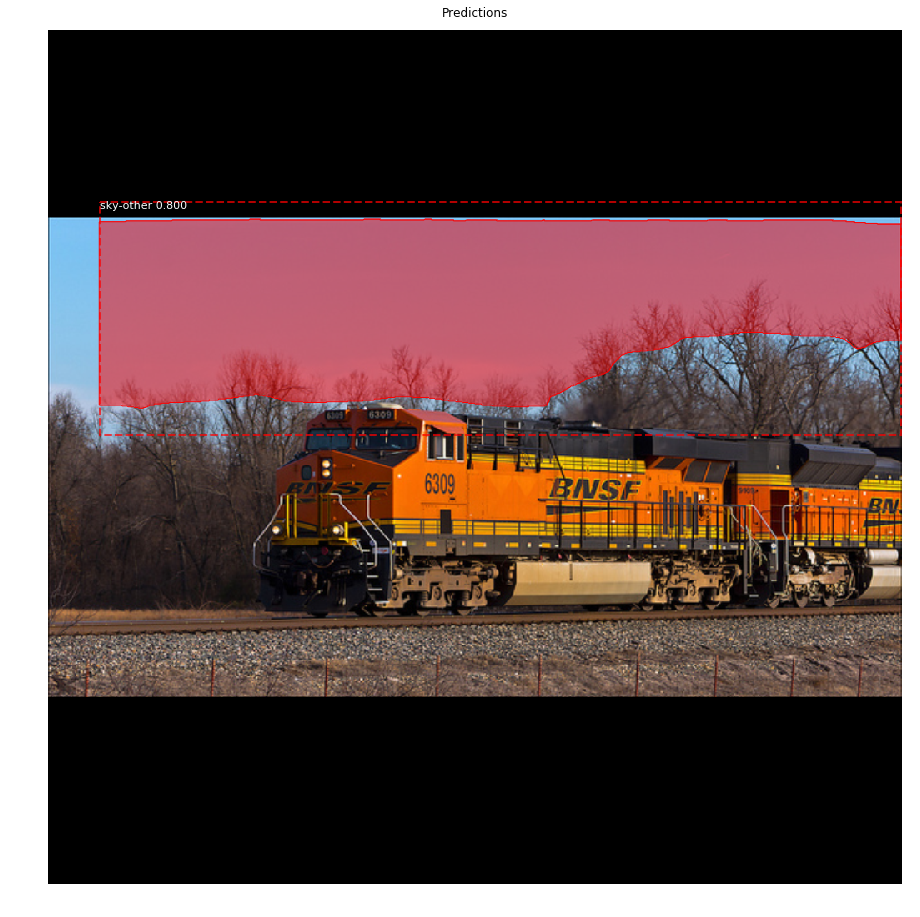

In [16]:
image_id = random.choice(dataset.image_ids)
#imgIds = my_coco.getImgIds()
#image_id = imgIds[np.random.randint(0, len(imgIds))]
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

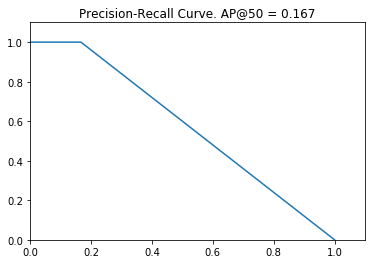

In [17]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

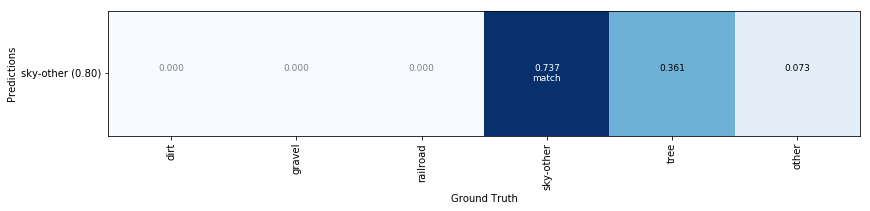

In [18]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [31]:
print(gt_class_id)
print(r['scores'][0])

[ 5  8 32 33 54 92]
0.841844


In [21]:

for c_id in r['class_ids']: 
    print(dataset.class_names[c_id])

other


In [24]:
import pandas as pd

## Create data structures for aggregate inspection

In [73]:
#agg_overlaps = pd.DataFrame(columns=dataset.class_names, index=dataset.class_names)
agg_overlaps = {}
agg_scores = {}

In [104]:
image_id = random.choice(dataset.image_ids)

aggregate = 0
while(aggregate < 1):
    
    #image_id = random.choice(dataset.image_ids)
    image_id = 274
    try:

        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        aggregate += 1
        
    except:
        continue
        
    # Run object detection
    results = model.detect([image], verbose=1)
    # Draw precision-recall curve
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
    
    #caputre scores
    for indx, c_id in enumerate(r['class_ids']):
        if dataset.class_names[c_id] in agg_scores.keys():
            agg_scores[dataset.class_names[c_id]].append(r['scores'][indx])
        else:
            agg_scores[dataset.class_names[c_id]] = [r['scores'][indx]]

    #capture overlaps
    for gt_indx, gt_cid in enumerate(gt_class_id):
        for r_indx, r_cid in enumerate(r['class_ids']):
            #Check if predict class is already a key.
            if dataset.class_names[r_cid] in agg_overlaps.keys():
                #If it is, then is ground-truth class a sub-key of this prediction key?
                if dataset.class_names[gt_cid] in agg_overlaps[dataset.class_names[r_cid]].keys():
                    agg_overlaps[dataset.class_names[r_cid]][dataset.class_names[gt_cid]].append(overlaps[r_indx][gt_indx])
                #Otherwise, create sub-key and initialize with overlap value
                else:
                    agg_overlaps[dataset.class_names[r_cid]][dataset.class_names[gt_cid]] = [overlaps[r_indx][gt_indx]]
            #Otherwise, create both key and sub-key and initialize with overlap value
            else:

                agg_overlaps[dataset.class_names[r_cid]] = {dataset.class_names[gt_cid] : [overlaps[r_indx][gt_indx]]}


                
print(agg_overlaps)    
print(agg_scores)
    
    

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 101)              min:    0.00000  max: 1024.00000
{'other': {'leaves': [0.0, 0.35238730984084599], 'clothes': [0.026176865954086893, 0.026176865954086893, 0.026176865954086893, 0.026176865954086893, 0.14065805209384755, 0.88396272406810172, 0.2945111313543512, 0.32443062990464128, 0.0046260339898186557, 0.05618901622164265, 0.25377401073273487], 'mountain': [0.0], 'plastic': [0.003721786322096922, 0.012972565990510526], 'platform': [0.42984099138016318], 'tree': [0.36821580805460141, 0.36821580805460141, 0.36821580805460141, 0.36821580805460141, 0.14321603258283691, 0.78007984185171675, 0.83948216563411082], 'wall-other': [0.14342372697482825, 0.50104992525462866, 0.067963893609874051, 0.50539083557951481, 0.68624640894124433], 'pavement': [0.0208738740379949

In [105]:
overlap_map = pd.DataFrame(columns=dataset.class_names, index=agg_overlaps.keys())
for pred_class in agg_overlaps.keys():
    for gt_class in agg_overlaps[pred_class].keys():
        #print("{} : {} = {}".format(pred_class, gt_class, np.mean(agg_overlaps[pred_class][gt_class])))
        overlap_map.loc[pred_class][gt_class] = np.mean(agg_overlaps[pred_class][gt_class])
        
overlap_map.fillna(0, inplace=True)

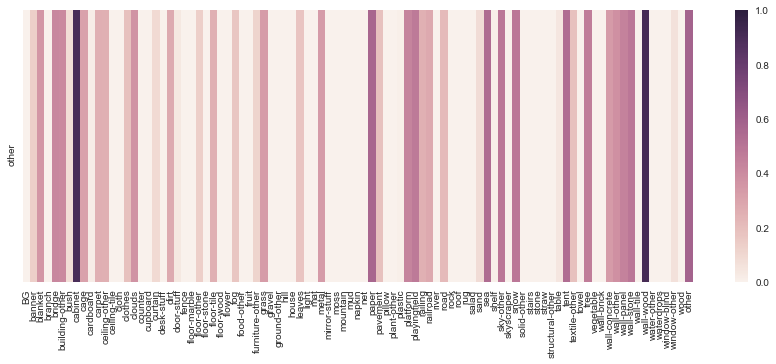

In [106]:
import seaborn as sns

fig = plt.figure(figsize=(15,5))
ax = fig.gca()

ax = sns.heatmap(data=overlap_map, vmin=0, vmax=1)
plt.show()

/Users/carlosbeas/anaconda/envs/conda3p5/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/carlosbeas/anaconda/envs/conda3p5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


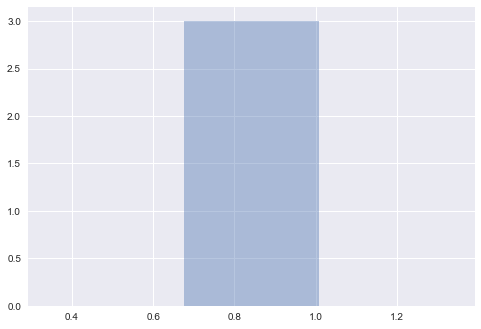

In [100]:
sns.distplot(agg_scores['other'])

In [36]:
for indx, c_id in enumerate(r['class_ids']):
    if dataset.class_names[c_id] in agg_scores.keys():
        agg_scores[dataset.class_names[c_id]].append(r['scores'][indx])
    else:
        agg_scores[dataset.class_names[c_id]] = [r['scores'][indx]]


    
agg_scores


{'other': [0.84184444]}

In [70]:
overlaps

array([[ 0.55045927,  0.02617687,  0.12135739,  0.00111488,  0.58463031,
         0.02087387,  0.05103284,  0.00330673,  0.36821581,  0.67623106]])

In [77]:
for gt_indx, gt_cid in enumerate(gt_class_id):
    for r_indx, r_cid in enumerate(r['class_ids']):
        #Check if predict class is already a key.
        if dataset.class_names[r_cid] in agg_overlaps.keys():
            #If it is, then is ground-truth class a sub-key of this prediction key?
            if dataset.class_names[gt_cid] in agg_overlaps[dataset.class_names[r_cid]].keys():
                agg_overlaps[dataset.class_names[r_cid]][dataset.class_names[gt_cid]].append(overlaps[r_indx][gt_indx])
            #Otherwise, create sub-key and initialize with overlap value
            else:
                agg_overlaps[dataset.class_names[r_cid]][dataset.class_names[gt_cid]] = [overlaps[r_indx][gt_indx]]
        #Otherwise, create both key and sub-key and initialize with overlap value
        else:
            
            agg_overlaps[dataset.class_names[r_cid]] = {dataset.class_names[gt_cid] : [overlaps[r_indx][gt_indx]]}
            
            
agg_overlaps

{'other': {'building-other': [0.55045927423406094,
   0.55045927423406094,
   0.55045927423406094,
   0.55045927423406094],
  'clothes': [0.026176865954086893,
   0.026176865954086893,
   0.026176865954086893,
   0.026176865954086893],
  'fog': [0.12135739029075208,
   0.12135739029075208,
   0.12135739029075208,
   0.12135739029075208],
  'light': [0.0011148791437728175,
   0.0011148791437728175,
   0.0011148791437728175,
   0.0011148791437728175],
  'metal': [0.58463030730567433,
   0.58463030730567433,
   0.58463030730567433,
   0.58463030730567433],
  'other': [0.67623106384815657,
   0.67623106384815657,
   0.67623106384815657,
   0.67623106384815657],
  'pavement': [0.020873874037994955,
   0.020873874037994955,
   0.020873874037994955,
   0.020873874037994955],
  'road': [0.051032835419189883,
   0.051032835419189883,
   0.051032835419189883,
   0.051032835419189883],
  'textile-other': [0.0033067325073850361,
   0.0033067325073850361,
   0.0033067325073850361,
   0.003306732507